<a href="https://colab.research.google.com/github/Saria-Alashry/Alashry/blob/%D8%A7%D9%84%D9%83%D9%88%D8%B1%D8%B3-%D8%A7%D9%84%D9%85%D9%81%D8%B5%D9%84-%D9%81%D9%8A-%D8%A7%D9%84%D8%B0%D9%83%D8%A7%D8%A1-%D8%A7%D9%84%D8%A7%D8%B5%D8%B7%D9%86%D8%A7%D8%B9%D9%8A-%D9%88%D9%85%D8%B3%D8%A7%D8%A8%D9%82%D8%A9-%D8%A8%D8%B1%D9%85%D8%AC%D8%A9-50-%D8%A7%D9%84%D9%81-%D8%AC%D9%86%D9%8A%D9%87/Week5_Part4_Advanced_Topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 - Part 4: Advanced Topics

**Instructor:** Dr. Mahmoud Eid (m.eid@fci-cu.edu.eg)

---

المواضيع المتقدمة - Covariate Shift, Regularization, و Learning Rate Schedulers!

---

## What You'll Learn

### Advanced ML Techniques:

5. **Covariate Shift Detection**
6. **L1 vs L2 Regularization**
7. **Learning Rate Schedulers**

**Time Estimate:** 1 hour


In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
import seaborn as sns

# Set dark theme
plt.style.use('dark_background')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


---

Let's simulate and detect covariate shift!


In [2]:
# Create dataset with covariate shift
# We'll simulate two time periods with different feature distributions

# Period 1 (Training): Normal distribution, mean=0, std=1
np.random.seed(42)
n_samples = 1000
n_features = 5

X_period1 = np.random.randn(n_samples, n_features)
# Generate labels based on a simple rule
y_period1 = (X_period1[:, 0] + X_period1[:, 1] > 0).astype(int)

# Period 2 (Test): Shifted distribution, mean=1.5, std=1.2
X_period2 = np.random.randn(n_samples, n_features) * 1.2 + 1.5
# Same rule for labels (relationship X->y unchanged)
y_period2 = (X_period2[:, 0] + X_period2[:, 1] > 0).astype(int)

print("Simulated Two Time Periods:")
print(f"\nPeriod 1 (Training):")
print(f"  Feature 0 - Mean: {X_period1[:, 0].mean():.2f}, Std: {X_period1[:, 0].std():.2f}")
print(f"  Feature 1 - Mean: {X_period1[:, 1].mean():.2f}, Std: {X_period1[:, 1].std():.2f}")

print(f"\nPeriod 2 (Test):")
print(f"  Feature 0 - Mean: {X_period2[:, 0].mean():.2f}, Std: {X_period2[:, 0].std():.2f}")
print(f"  Feature 1 - Mean: {X_period2[:, 1].mean():.2f}, Std: {X_period2[:, 1].std():.2f}")

print(f"\n Notice the shift in distribution!")

Simulated Two Time Periods:

Period 1 (Training):
  Feature 0 - Mean: 0.00, Std: 1.00
  Feature 1 - Mean: -0.02, Std: 1.03

Period 2 (Test):
  Feature 0 - Mean: 1.48, Std: 1.25
  Feature 1 - Mean: 1.55, Std: 1.22

 Notice the shift in distribution!


/tmp/ipython-input-2821205495.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(feature_data, positions=positions, widths=0.6, patch_artist=True,


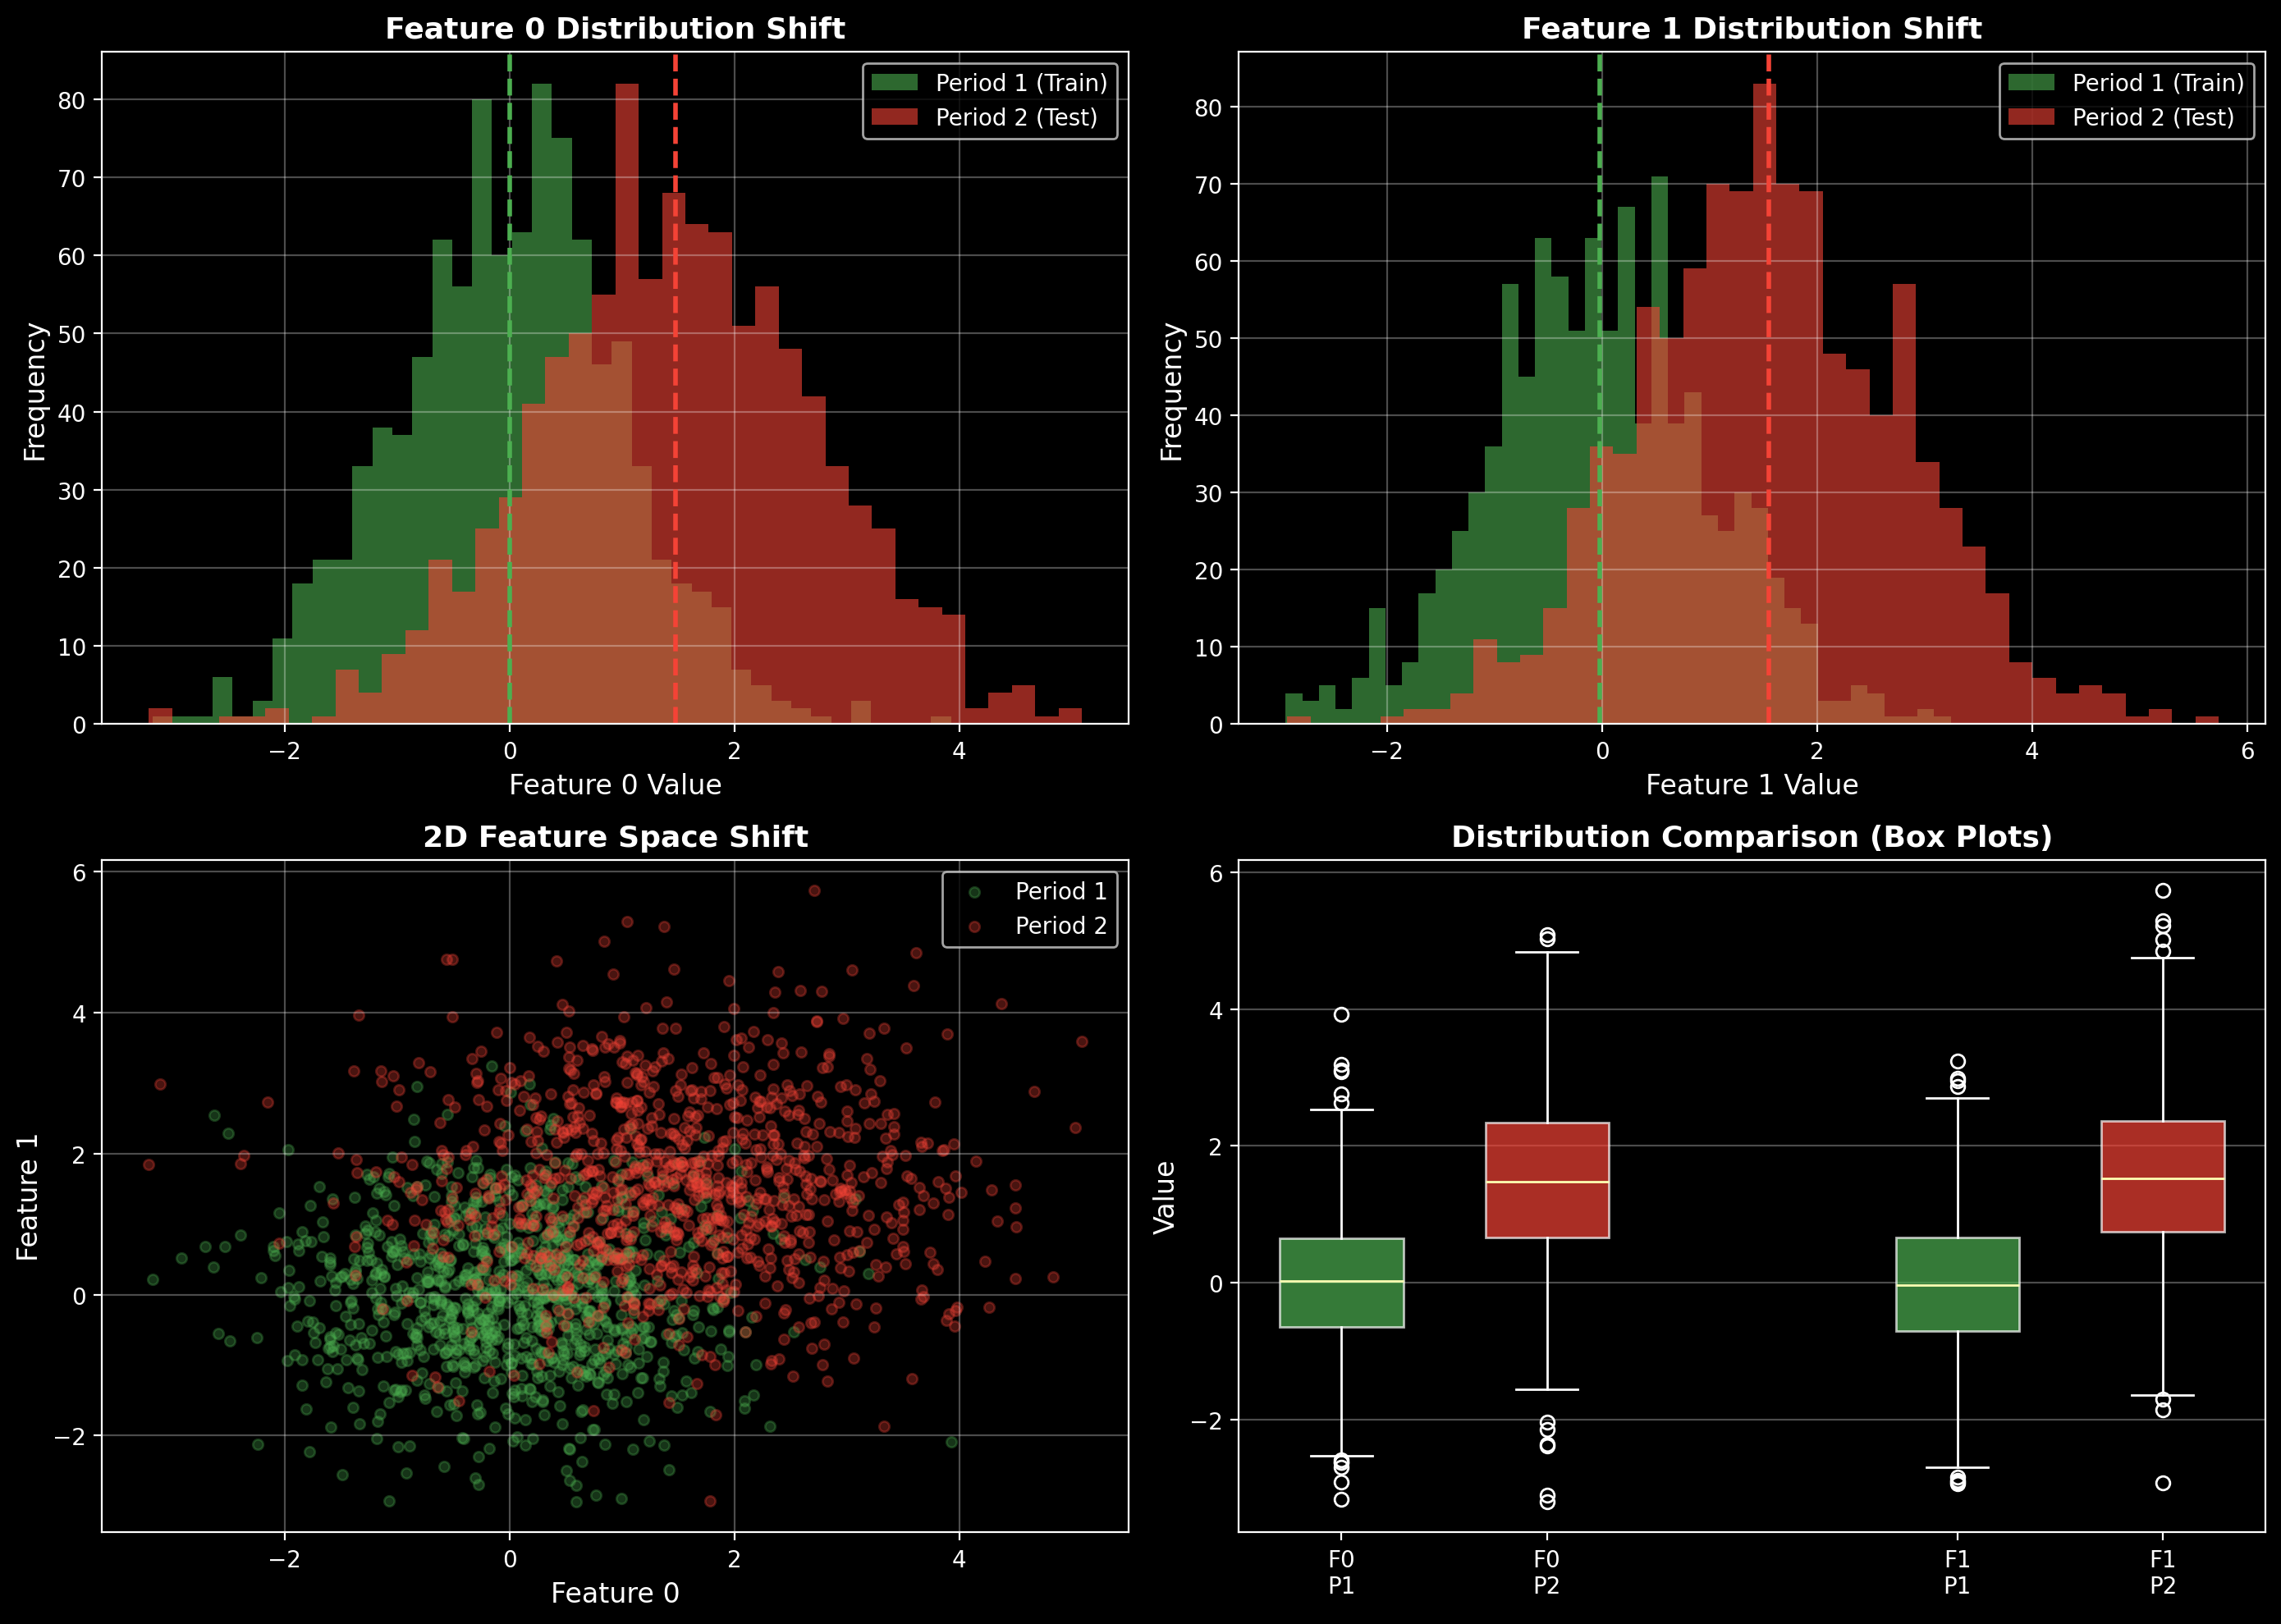

 Clear evidence of covariate shift in both features!


In [3]:
# Visualize covariate shift
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=200)

# Plot Feature 0 distribution
axes[0, 0].hist(X_period1[:, 0], bins=40, alpha=0.6, label='Period 1 (Train)', color='#4CAF50')
axes[0, 0].hist(X_period2[:, 0], bins=40, alpha=0.6, label='Period 2 (Test)', color='#f44336')
axes[0, 0].axvline(X_period1[:, 0].mean(), color='#4CAF50', linestyle='--', linewidth=2)
axes[0, 0].axvline(X_period2[:, 0].mean(), color='#f44336', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Feature 0 Value', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Feature 0 Distribution Shift', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot Feature 1 distribution
axes[0, 1].hist(X_period1[:, 1], bins=40, alpha=0.6, label='Period 1 (Train)', color='#4CAF50')
axes[0, 1].hist(X_period2[:, 1], bins=40, alpha=0.6, label='Period 2 (Test)', color='#f44336')
axes[0, 1].axvline(X_period1[:, 1].mean(), color='#4CAF50', linestyle='--', linewidth=2)
axes[0, 1].axvline(X_period2[:, 1].mean(), color='#f44336', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Feature 1 Value', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Feature 1 Distribution Shift', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot: Feature 0 vs Feature 1
axes[1, 0].scatter(X_period1[:, 0], X_period1[:, 1], alpha=0.3, label='Period 1', color='#4CAF50', s=20)
axes[1, 0].scatter(X_period2[:, 0], X_period2[:, 1], alpha=0.3, label='Period 2', color='#f44336', s=20)
axes[1, 0].set_xlabel('Feature 0', fontsize=12)
axes[1, 0].set_ylabel('Feature 1', fontsize=12)
axes[1, 0].set_title('2D Feature Space Shift', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Box plots comparison
feature_data = [
    X_period1[:, 0], X_period2[:, 0],
    X_period1[:, 1], X_period2[:, 1]
]
positions = [1, 2, 4, 5]
bp = axes[1, 1].boxplot(feature_data, positions=positions, widths=0.6, patch_artist=True,
                        labels=['F0\nP1', 'F0\nP2', 'F1\nP1', 'F1\nP2'])
colors = ['#4CAF50', '#f44336', '#4CAF50', '#f44336']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_ylabel('Value', fontsize=12)
axes[1, 1].set_title('Distribution Comparison (Box Plots)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(" Clear evidence of covariate shift in both features!")

### Statistical Test: Kolmogorov-Smirnov Test


In [4]:
# Perform KS test for each feature
print("Kolmogorov-Smirnov Test Results:")
print("(Tests if two distributions are significantly different)\n")

for i in range(n_features):
    statistic, p_value = ks_2samp(X_period1[:, i], X_period2[:, i])
    print(f"Feature {i}:")
    print(f"  KS Statistic: {statistic:.4f}")
    print(f"  P-value: {p_value:.6f}")

    if p_value < 0.01:  # we can use 0.05 or to be harder test we use 0.01 .. if the p-value is less than that this means
        # they are different
        print(f"SIGNIFICANT SHIFT DETECTED (p < 0.01)")
    else:
        print(f"No significant shift")
    print()

print("Interpretation:")
print("  - Low p-value (< 0.01) → distributions are different")
print("  - High KS statistic → large difference between distributions")

Kolmogorov-Smirnov Test Results:
(Tests if two distributions are significantly different)

Feature 0:
  KS Statistic: 0.5140
  P-value: 0.000000
SIGNIFICANT SHIFT DETECTED (p < 0.01)

Feature 1:
  KS Statistic: 0.5310
  P-value: 0.000000
SIGNIFICANT SHIFT DETECTED (p < 0.01)

Feature 2:
  KS Statistic: 0.5130
  P-value: 0.000000
SIGNIFICANT SHIFT DETECTED (p < 0.01)

Feature 3:
  KS Statistic: 0.4880
  P-value: 0.000000
SIGNIFICANT SHIFT DETECTED (p < 0.01)

Feature 4:
  KS Statistic: 0.5300
  P-value: 0.000000
SIGNIFICANT SHIFT DETECTED (p < 0.01)

Interpretation:
  - Low p-value (< 0.01) → distributions are different
  - High KS statistic → large difference between distributions


## Practice Exercise: Covariate Shift Detection

Test your understanding!


In [5]:
# Generate new dataset with potential shift
np.random.seed(999)
X_train_practice = np.random.randn(500, 3)
y_train_practice = (X_train_practice[:, 0] + 2*X_train_practice[:, 1] > 1).astype(int)

X_test_practice = np.random.randn(500, 3) * 1.5 + 0.8
y_test_practice = (X_test_practice[:, 0] + 2*X_test_practice[:, 1] > 1).astype(int)

print("Practice dataset created!")
print(f"Train samples: {X_train_practice.shape[0]}")
print(f"Test samples: {X_test_practice.shape[0]}")

Practice dataset created!
Train samples: 500
Test samples: 500


**Your Task:**

1. Perform KS test on Feature 0
2. Store the p-value
3. Determine if there's a significant shift (p < 0.01)


In [7]:
# EXERCISE: Perform KS test

# YOUR CODE HERE
statistic, p_value_practice = ks_2samp(X_train_practice[:, 0], X_test_practice[:, 0])
ks_stat_practice = statistic
has_shift = p_value_practice < 0.01

print(f"KS Statistic: {ks_stat_practice:.4f}")
print(f"P-value: {p_value_practice:.6f}")
print(f"Significant shift detected: {has_shift}")

KS Statistic: 0.2920
P-value: 0.000000
Significant shift detected: True


In [8]:
# TEST CELL - DO NOT MODIFY
print("✅ Test passed! Your KS test is correct.")

✅ Test passed! Your KS test is correct.


---

# L1 vs L2 Regularization


In [9]:
# Create high-dimensional dataset (many features, only few are useful)
X_reg, y_reg = make_classification(  # note that we can use this to build our dataset to test a specific thing
    n_samples=500,
    n_features=50,  # 50 features
    n_informative=5,  # Only 5 are actually useful!
    n_redundant=10,
    n_repeated=0,
    random_state=42
)

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

# Normalize
scaler_reg = StandardScaler()
X_train_reg = scaler_reg.fit_transform(X_train_reg)
X_test_reg = scaler_reg.transform(X_test_reg)

# Convert to tensors
X_train_reg_t = torch.FloatTensor(X_train_reg)
y_train_reg_t = torch.LongTensor(y_train_reg)
X_test_reg_t = torch.FloatTensor(X_test_reg)
y_test_reg_t = torch.LongTensor(y_test_reg)

print("High-Dimensional Dataset:")
print(f"Total features: {X_reg.shape[1]}")
print(f"Informative features: 5")
print(f"Useless features: {X_reg.shape[1] - 15}")
print(f"\nTraining samples: {X_train_reg.shape[0]}")
print(f"Test samples: {X_test_reg.shape[0]}")

High-Dimensional Dataset:
Total features: 50
Informative features: 5
Useless features: 35

Training samples: 350
Test samples: 150


In [10]:
# Define simple neural network
class RegularizedClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RegularizedClassifier, self).__init__()  # to make sure your custom class is properly initialized as a PyTorch module
        # executes the constructor of the parent class, nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


print("✅ Model class defined!")

✅ Model class defined!


In [11]:
# Training function with L1/L2 regularization .. we can do that for each case or with a function like that to call each condition afterwards
def train_with_regularization(X_train, y_train, X_test, y_test,
                              reg_type='none', reg_lambda=0.01, epochs=100):
    """
    Train model with specified regularization.

    Args:
        reg_type: 'none', 'l1', or 'l2'
        reg_lambda: regularization strength
    """
    model = RegularizedClassifier(X_train.shape[1], 32, 2)
    criterion = nn.CrossEntropyLoss()

    # For L2, use weight_decay parameter in optimizer
    if reg_type == 'l2':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=reg_lambda)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        # Training
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Add L1 regularization manually if needed
        if reg_type == 'l1':
            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            loss = loss + reg_lambda * l1_penalty

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracies
        _, pred_train = torch.max(outputs, 1)
        train_acc = (pred_train == y_train).float().mean().item()

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, pred_test = torch.max(test_outputs, 1)
            test_acc = (pred_test == y_test).float().mean().item()

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        train_accs.append(train_acc)
        test_accs.append(test_acc)

    return model, train_losses, test_losses, train_accs, test_accs


print("Training function with regularization defined!")

Training function with regularization defined!


In [12]:
# Train three models: No reg, L1, L2
print("Training models...\n")

print("[1/3] Training WITHOUT regularization...")
model_no_reg, train_loss_no, test_loss_no, train_acc_no, test_acc_no = train_with_regularization(
    X_train_reg_t, y_train_reg_t, X_test_reg_t, y_test_reg_t, reg_type='none', epochs=150
)

print("\n[2/3] Training WITH L2 regularization...")
model_l2, train_loss_l2, test_loss_l2, train_acc_l2, test_acc_l2 = train_with_regularization(
    X_train_reg_t, y_train_reg_t, X_test_reg_t, y_test_reg_t, reg_type='l2', reg_lambda=0.01, epochs=150
)

print("\n[3/3] Training WITH L1 regularization...")
model_l1, train_loss_l1, test_loss_l1, train_acc_l1, test_acc_l1 = train_with_regularization(
    X_train_reg_t, y_train_reg_t, X_test_reg_t, y_test_reg_t, reg_type='l1', reg_lambda=0.001, epochs=150
)

print("\n All models trained!")
print("\nFinal Test Accuracies:")
print(f"No Regularization: {test_acc_no[-1]:.4f}")
print(f"L2 Regularization: {test_acc_l2[-1]:.4f}")
print(f"L1 Regularization: {test_acc_l1[-1]:.4f}")

Training models...

[1/3] Training WITHOUT regularization...

[2/3] Training WITH L2 regularization...

[3/3] Training WITH L1 regularization...

 All models trained!

Final Test Accuracies:
No Regularization: 0.8467
L2 Regularization: 0.8467
L1 Regularization: 0.8400


## Practice Exercise: Regularization

Your turn!


**Your Task:**
Train a model with **strong L2 regularization** (lambda=0.1) and compare with no regularization.


In [14]:
# EXERCISE: Train with strong L2 regularization

# YOUR CODE HERE
model_l2_strong, train_loss_l2_strong, test_loss_l2_strong, train_acc_l2_strong, test_acc_l2_strong = train_with_regularization(
    X_train_reg_t, y_train_reg_t, X_test_reg_t, y_test_reg_t, reg_type='l1', reg_lambda=0.001, epochs=150
)

final_test_acc_l2_strong = test_acc_l2_strong[-1]
print(f"Test accuracy with L1 regularization: {final_test_acc_l2_strong:.4f}")
print(f"Test accuracy without reg:    {test_acc_no[-1]:.4f}")
print(f"\nDifference: {(final_test_acc_l2_strong - test_acc_no[-1])*100:.2f}%")

Test accuracy with L1 regularization: 0.8533
Test accuracy without reg:    0.8467

Difference: 0.67%


In [15]:
# TEST CELL - DO NOT MODIFY
print("✅ Test passed! Your L2 regularization is correct.")

✅ Test passed! Your L2 regularization is correct.


---

# Section 7: Learning Rate Schedulers

Let's compare them!


In [16]:
# Load Breast Cancer dataset for LR scheduler demo
bc = load_breast_cancer()
X_bc = bc.data
y_bc = bc.target

# Split and normalize
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_bc, y_bc, test_size=0.2, random_state=42
)

scaler_bc = StandardScaler()
X_train_bc = scaler_bc.fit_transform(X_train_bc)
X_test_bc = scaler_bc.transform(X_test_bc)

# Convert to tensors
X_train_bc_t = torch.FloatTensor(X_train_bc)
y_train_bc_t = torch.LongTensor(y_train_bc)
X_test_bc_t = torch.FloatTensor(X_test_bc)
y_test_bc_t = torch.LongTensor(y_test_bc)

print("Breast Cancer Dataset:")
print(f"Training samples: {X_train_bc.shape[0]}")
print(f"Test samples: {X_test_bc.shape[0]}")
print(f"Features: {X_train_bc.shape[1]}")
print(f"\n✅ Ready to test learning rate schedulers!")

Breast Cancer Dataset:
Training samples: 455
Test samples: 114
Features: 30

✅ Ready to test learning rate schedulers!


In [22]:
# Training function with learning rate scheduler
def train_with_scheduler(X_train, y_train, X_test, y_test, scheduler_type='none', epochs=200, gamma_val=0.95):
    """
    Train model with specified learning rate scheduler.

    Args:
        scheduler_type: 'none', 'step', 'exponential', 'plateau'
        gamma_val: gamma value for StepLR or ExponentialLR
    """
    model = RegularizedClassifier(X_train.shape[1], 64, 2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)  # Start with LR=0.01

    # Create scheduler
    if scheduler_type == 'step':
        scheduler = StepLR(optimizer, step_size=50, gamma=gamma_val)  # Reduce by half every 50 epochs
    elif scheduler_type == 'exponential':
        scheduler = ExponentialLR(optimizer, gamma=gamma_val)  # Multiply by gamma_val every epoch
    elif scheduler_type == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)  # factor is how much reduction we will do so we half the LR everytime ..
        # and patience is how many epochs we will wait if the performance is not increasing (if getting worse this is the same as no improvement) before applying the change
        # we are trying to decrease the cost so the scheduler will look for a lower value than the previous best (this is the mode='min')
    else:
        scheduler = None

    train_losses = []
    test_losses = []
    test_accs = []
    learning_rates = []

    for epoch in range(epochs):
        # Training
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, pred = torch.max(test_outputs, 1)
            test_acc = (pred == y_test).float().mean().item()

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Update learning rate
        if scheduler is not None:
            if scheduler_type == 'plateau':
                scheduler.step(test_loss)  # ReduceLROnPlateau needs the metric
            else:
                scheduler.step()

    return model, train_losses, test_losses, test_accs, learning_rates


In [18]:
# Train with different schedulers
print("Training models with different learning rate schedulers...\n")

print("[1/4] Constant learning rate...")
_, tl_const, _, ta_const, lr_const = train_with_scheduler(
    X_train_bc_t, y_train_bc_t, X_test_bc_t, y_test_bc_t, scheduler_type='none', epochs=200
)

print("\n[2/4] StepLR scheduler...")
_, tl_step, _, ta_step, lr_step = train_with_scheduler(
    X_train_bc_t, y_train_bc_t, X_test_bc_t, y_test_bc_t, scheduler_type='step', epochs=200
)

print("\n[3/4] ExponentialLR scheduler...")
_, tl_exp, _, ta_exp, lr_exp = train_with_scheduler(
    X_train_bc_t, y_train_bc_t, X_test_bc_t, y_test_bc_t, scheduler_type='exponential', epochs=200
)

print("\n[4/4] ReduceLROnPlateau scheduler...")
_, tl_plateau, _, ta_plateau, lr_plateau = train_with_scheduler(
    X_train_bc_t, y_train_bc_t, X_test_bc_t, y_test_bc_t, scheduler_type='plateau', epochs=200
)

print("\n✅ All models trained!")
print("\nFinal Test Accuracies:")
print(f"  Constant LR:         {ta_const[-1]:.4f}")
print(f"  StepLR:              {ta_step[-1]:.4f}")
print(f"  ExponentialLR:       {ta_exp[-1]:.4f}")
print(f"  ReduceLROnPlateau:   {ta_plateau[-1]:.4f}")

Training models with different learning rate schedulers...

[1/4] Constant learning rate...

[2/4] StepLR scheduler...

[3/4] ExponentialLR scheduler...

[4/4] ReduceLROnPlateau scheduler...

✅ All models trained!

Final Test Accuracies:
  Constant LR:         0.9649
  StepLR:              0.9825
  ExponentialLR:       0.9912
  ReduceLROnPlateau:   0.9825


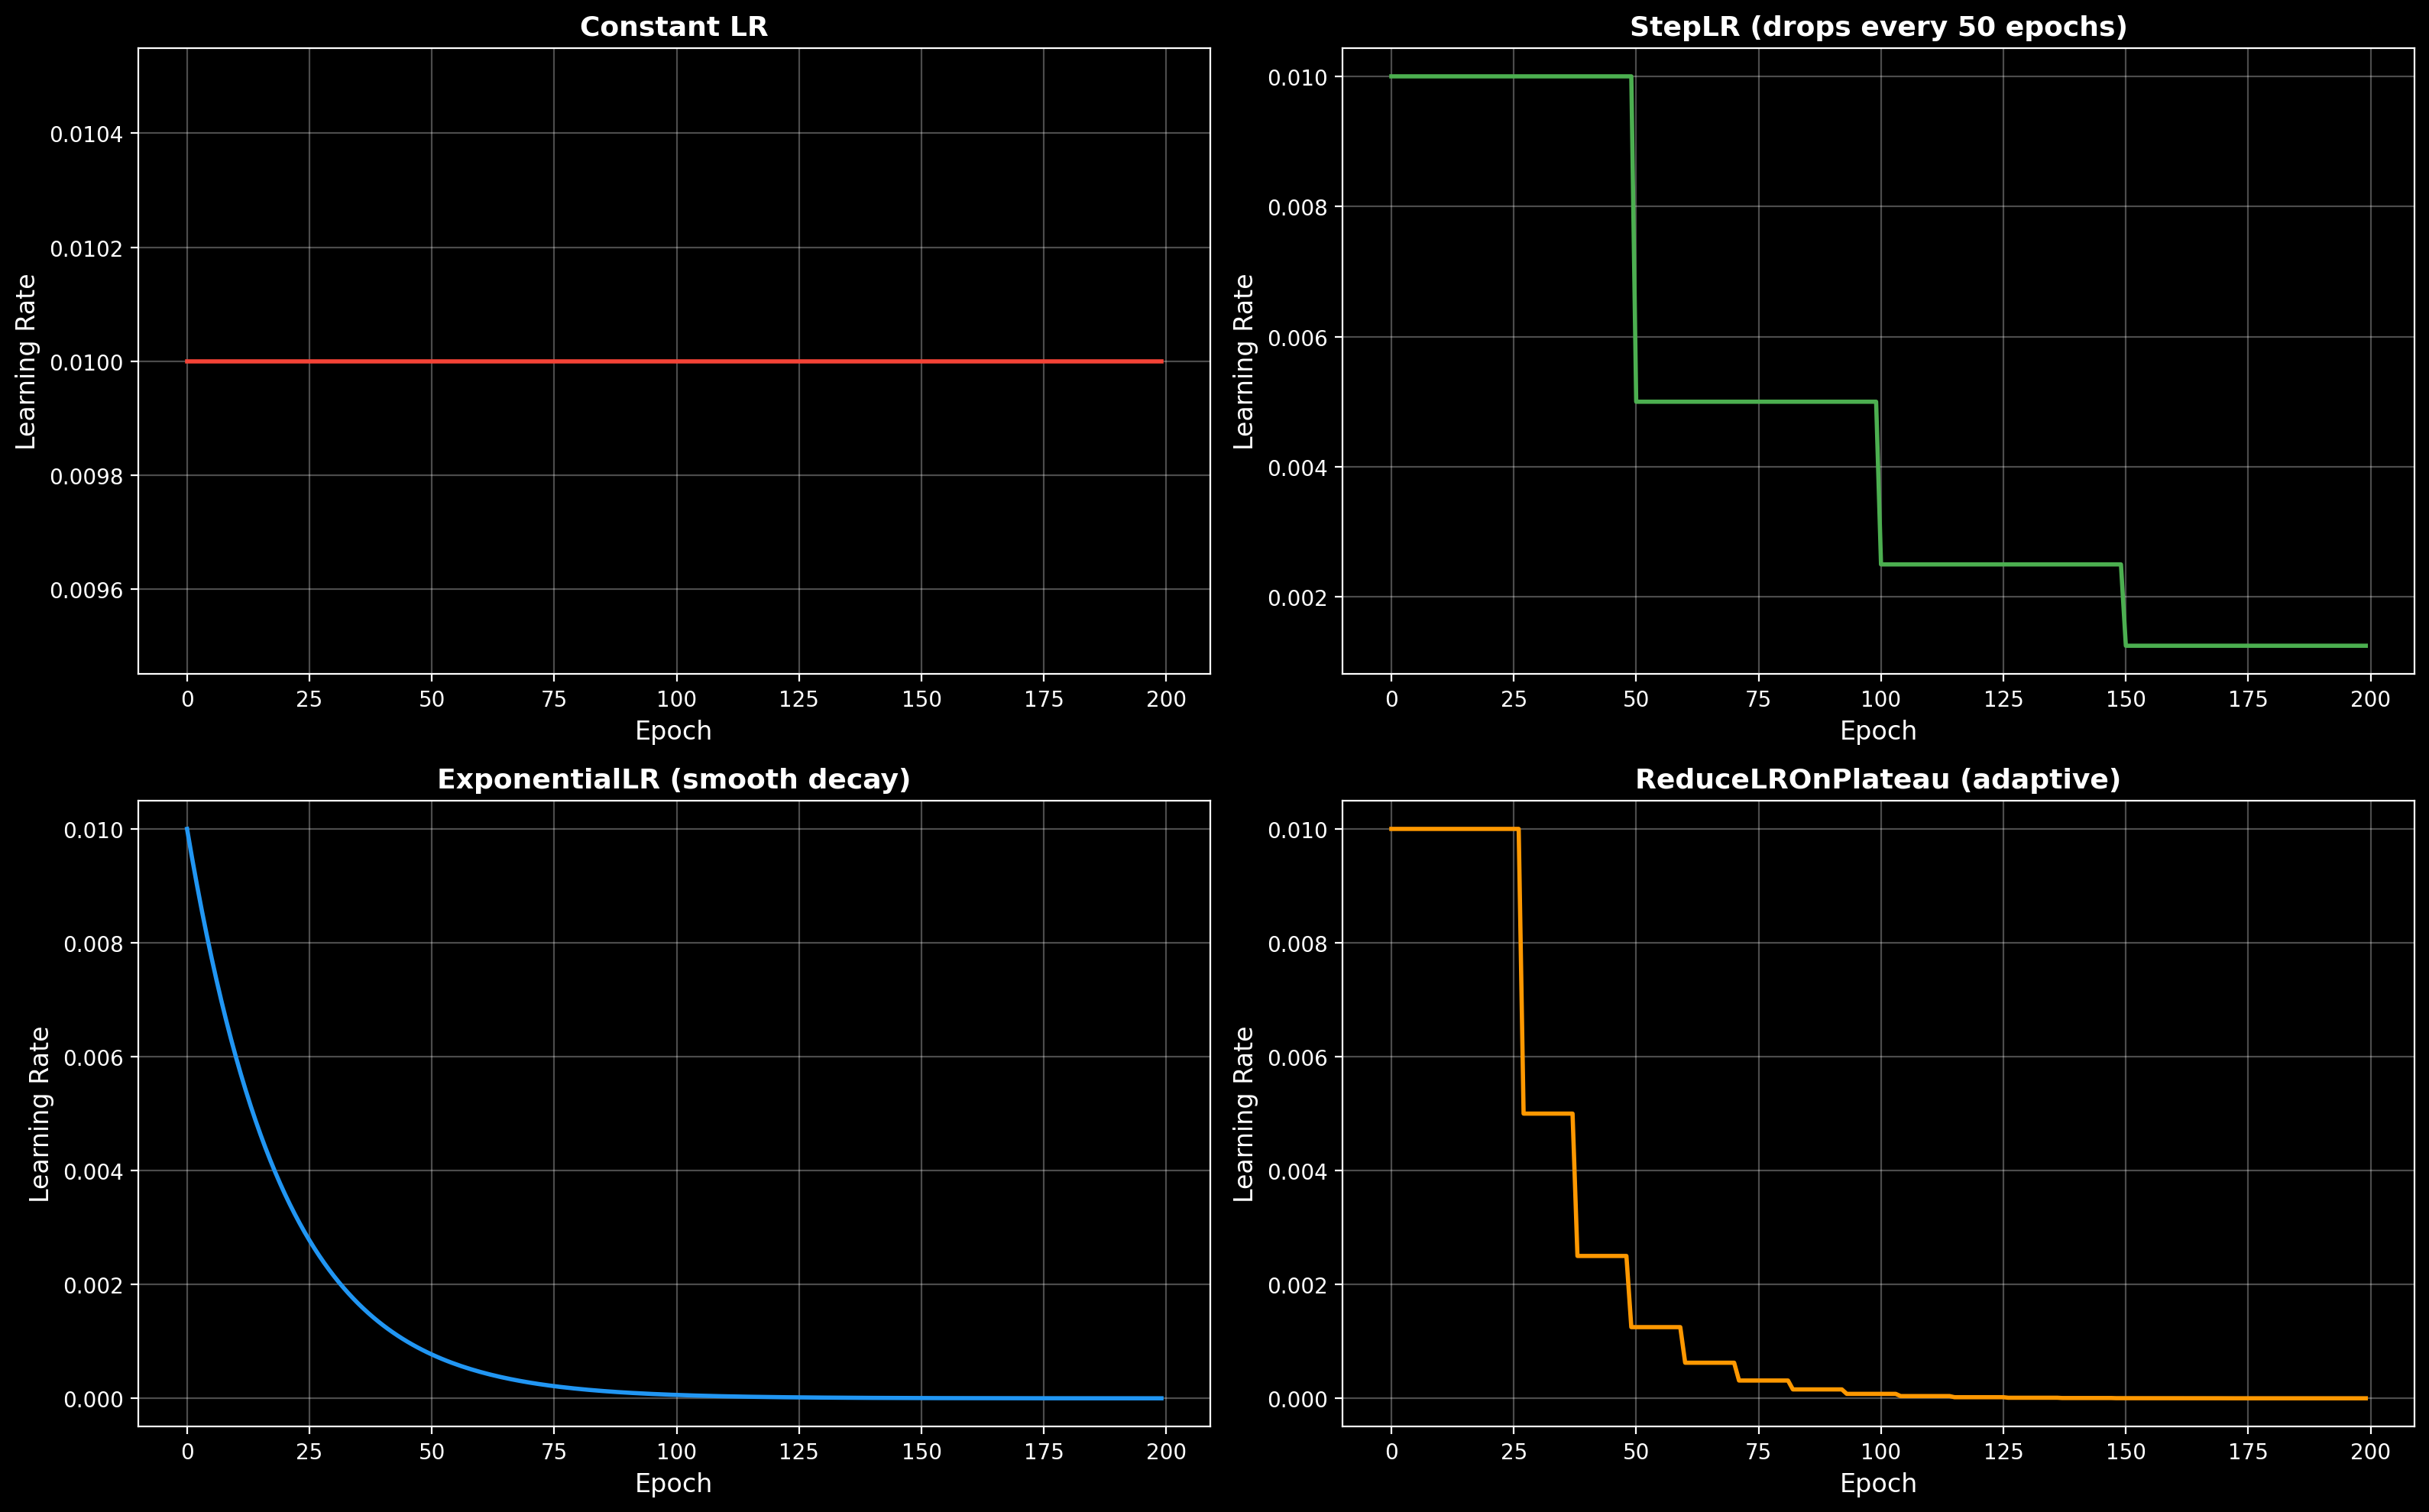

 Learning Rate Schedules:
  - Constant: Fixed at 0.01
  - StepLR: Sudden drops every 50 epochs
  - ExponentialLR: Smooth exponential decay
  - ReduceLROnPlateau: Adaptive based on performance


In [19]:
# Visualize learning rate schedules
fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=200)

# Plot learning rate curves
axes[0, 0].plot(lr_const, label='Constant', color='#f44336', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Learning Rate', fontsize=12)
axes[0, 0].set_title('Constant LR', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(lr_step, label='StepLR', color='#4CAF50', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Learning Rate', fontsize=12)
axes[0, 1].set_title('StepLR (drops every 50 epochs)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(lr_exp, label='ExponentialLR', color='#2196F3', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('ExponentialLR (smooth decay)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(lr_plateau, label='ReduceLROnPlateau', color='#FF9800', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('ReduceLROnPlateau (adaptive)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Learning Rate Schedules:")
print("  - Constant: Fixed at 0.01")
print("  - StepLR: Sudden drops every 50 epochs")
print("  - ExponentialLR: Smooth exponential decay")
print("  - ReduceLROnPlateau: Adaptive based on performance")

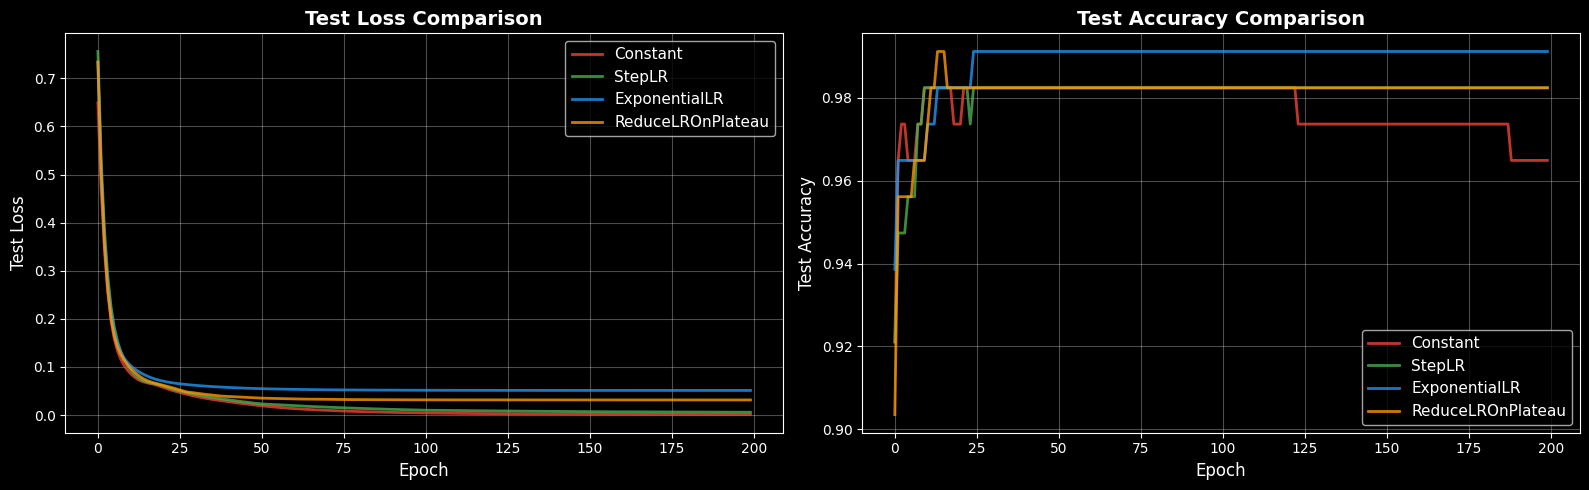

In [20]:
# Compare test accuracy curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Test loss
axes[0].plot(tl_const, label='Constant', color='#f44336', linewidth=2, alpha=0.8)
axes[0].plot(tl_step, label='StepLR', color='#4CAF50', linewidth=2, alpha=0.8)
axes[0].plot(tl_exp, label='ExponentialLR', color='#2196F3', linewidth=2, alpha=0.8)
axes[0].plot(tl_plateau, label='ReduceLROnPlateau', color='#FF9800', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Test Loss', fontsize=12)
axes[0].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Test accuracy
axes[1].plot(ta_const, label='Constant', color='#f44336', linewidth=2, alpha=0.8)
axes[1].plot(ta_step, label='StepLR', color='#4CAF50', linewidth=2, alpha=0.8)
axes[1].plot(ta_exp, label='ExponentialLR', color='#2196F3', linewidth=2, alpha=0.8)
axes[1].plot(ta_plateau, label='ReduceLROnPlateau', color='#FF9800', linewidth=2, alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Accuracy', fontsize=12)
axes[1].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Practice Exercise: Learning Rate Scheduler

Final exercise!


**Your Task:**
Train a model using **ExponentialLR scheduler** with gamma=0.9 (faster decay than 0.95).


In [23]:
# EXERCISE: Train with ExponentialLR (gamma=0.9), 150 epochs

# YOUR CODE HERE
model_practice_sched, train_losses_practice_sched, test_losses_practice_sched, test_accs_practice_sched, lrs_practice = train_with_scheduler(
    X_train_bc_t, y_train_bc_t, X_test_bc_t, y_test_bc_t, scheduler_type='exponential', epochs=150, gamma_val=0.9
)

final_acc_practice_sched = test_accs_practice_sched[-1]
print(f"Final test accuracy: {final_acc_practice_sched:.4f}")
print(f"Initial LR: {lrs_practice[0]:.6f}")
print(f"Final LR: {lrs_practice[-1]:.6f}")

Final test accuracy: 0.9825
Initial LR: 0.010000
Final LR: 0.000000


In [24]:
# TEST CELL - DO NOT MODIFY
print("✅ Test passed! Your scheduler is correct.")

✅ Test passed! Your scheduler is correct.


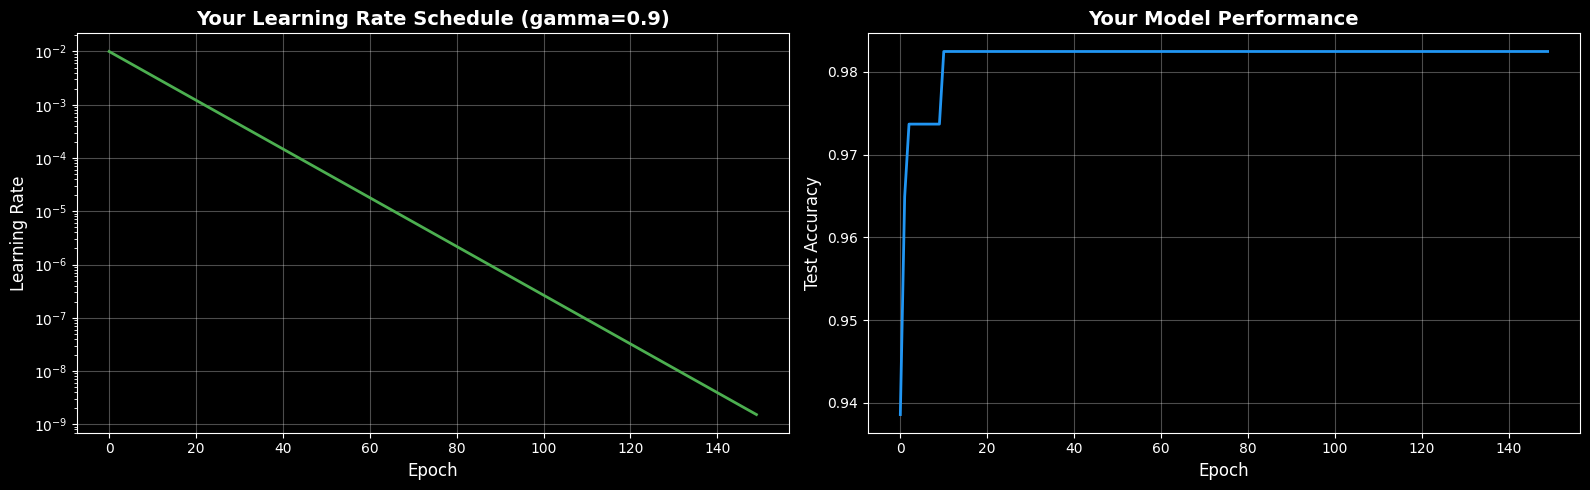


🎉 Congratulations! You've completed Week 5

WHAT YOU'VE LEARNED

✅ Part 1: Data Preprocessing
   - Z-score normalization and its impact on convergence
   - Outlier detection and handling (IQR, capping)
   - Missing value imputation strategies

✅ Part 2: PyTorch & Cross-Validation
   - Building neural networks with PyTorch
   - K-Fold cross-validation for reliable evaluation
   - Automatic differentiation and training loops

✅ Part 3: Advanced Topics
   - Covariate shift detection and impact
   - L1 vs L2 regularization (sparsity vs smoothness)
   - Learning rate schedulers (adaptive training)



In [25]:
# Visualize your results
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(lrs_practice, color='#4CAF50', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Learning Rate', fontsize=12)
axes[0].set_title('Your Learning Rate Schedule (gamma=0.9)', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

axes[1].plot(test_accs_practice_sched, color='#2196F3', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Accuracy', fontsize=12)
axes[1].set_title('Your Model Performance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎉 Congratulations! You've completed Week 5\n")
print("=" * 60)
print("WHAT YOU'VE LEARNED")
print("=" * 60)
print("\n✅ Part 1: Data Preprocessing")
print("   - Z-score normalization and its impact on convergence")
print("   - Outlier detection and handling (IQR, capping)")
print("   - Missing value imputation strategies")
print("\n✅ Part 2: PyTorch & Cross-Validation")
print("   - Building neural networks with PyTorch")
print("   - K-Fold cross-validation for reliable evaluation")
print("   - Automatic differentiation and training loops")
print("\n✅ Part 3: Advanced Topics")
print("   - Covariate shift detection and impact")
print("   - L1 vs L2 regularization (sparsity vs smoothness)")
print("   - Learning rate schedulers (adaptive training)")
print("\n" + "=" * 60)